> __Purpose:__ This NB tests a CNN in the agglomerative model clustering procedure. With later finetuning. Uses the previously developed PyTorch code

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn.cross_decomposition import CCA
#from sklearn.decomposition import PCA
#import seaborn as sns
#import copy

np.random.seed(42) 

#from moments_engr import *
from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from full_study_funcs import * 
from revamped_model_classes import *
from hyperparam_tuned_configs import *

import os
cwd = os.getcwd()
print("Current Working Directory: ", cwd)


Current Working Directory:  c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj


In [2]:
MODEL_STR = "ELEC573Net"
MY_CONFIG = ELEC573Net_config
SAVE_FIGS = False
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Train/test user split: 24/8



In [ ]:
expdef_df = load_expdef_gestures(feateng_method=MY_CONFIG["feature_engr"])

print(expdef_df.shape)
expdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [4]:
all_participants = expdef_df['Participant'].unique()
# Shuffle the participants
np.random.shuffle(all_participants)
# Split into two groups
#train_participants = all_participants[:24]  # First 24 participants
test_participants = all_participants[24:]  # Remaining 8 participants

In [5]:
# Prepare data
data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
)

In [6]:
features_df = pd.DataFrame(data_splits['train']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
train_df['Cluster_ID'] = label_encoder.fit_transform(train_df['participant_ids'])

features_df = pd.DataFrame(data_splits['intra_subject_test']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
test_df = pd.concat([features_df, pd.Series(data_splits['intra_subject_test']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['intra_subject_test']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
test_df['Cluster_ID'] = label_encoder.fit_transform(test_df['participant_ids'])

# ENTIRELY WITHHOLDING CROSS CLUSTER DATASET (NOVEL TEST SUBJECTS) FOR NOW. 
# TODO: Pull this from other file
#test_df
#features_df = pd.DataFrame(data_splits['train']['features'])
## Create a new column 'features' that contains all 80 columns as lists
#features_df['features'] = features_df.apply(lambda row: row.tolist(), axis=1)
## Keep only the new combined column
#features_df = features_df[['features']]
## Combine with labels and participant_ids into a single DataFrame
#train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)

In [7]:
data_dfs_dict = {'train':train_df, 'test':test_df}

# Need to update Cluster_ID col at the end of each round, for both dfs

In [8]:
train_df.head()

,feature,Gesture_Encoded,participant_ids,Cluster_ID
0,"[4.0728441780827485, -6.216633410388578, -15.0...",0,P128,22
1,"[4.842766138855771, -7.933026853320965, -18.38...",0,P128,22
2,"[4.343725560839635, -6.20391996380322, -15.560...",0,P128,22
3,"[4.972292120731378, -6.996600730998998, -17.60...",0,P128,22
4,"[4.942130684716379, -6.513267267205743, -16.81...",0,P128,22


In [9]:
# FIRST TIME ONLY: MUST ACTUALLY RUN CLUSTERING!

# Load the CLUSTERING RESULTS DATA
#raise ValueError("UPDATE THIS")
with open('C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\results\\clustering_models\\20250210_2032\\spectralFE80_ELEC573Net_agglo_merge_res.pkl', 'rb') as f:
    merge_log = pickle.load(f)
    intra_cluster_performance = pickle.load(f)
    cross_cluster_performance = pickle.load(f)
    nested_clus_model_dict = pickle.load(f)

print("Data has been loaded successfully!")

Data has been loaded successfully!


# Finetuning Process

In [10]:
cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)

Cluster list:
[8, 34, 36, 37, 38, 41]


In [11]:
# This needs to be formalized......

cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)
print()
print("Cluster 41 model:")
print(nested_clus_model_dict['Iter18'][41])

Cluster list:
[8, 34, 36, 37, 38, 41]

Cluster 41 model:
ELEC573Net(
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(2,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
full_path = "C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\models\\20250207_1608"
print("Full Path:", full_path)
# Load the pretrained model
pretrained_generic_model = ELEC573Net(MY_CONFIG)
pretrained_generic_model.load_state_dict(torch.load(full_path+"\\pretrained_ELEC573Net_model.pth"))

Full Path: C:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\models\20250207_1608


<All keys matched successfully>

In [13]:
cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)
print()
print("Cluster 41 model:")
print(nested_clus_model_dict['Iter18'][41])

Cluster list:
[8, 34, 36, 37, 38, 41]

Cluster 41 model:
ELEC573Net(
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(2,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
# Prepare data
one_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=1, finetuning_trials_per_gesture=1,
)

three_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=3, finetuning_trials_per_gesture=3,
)

five_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=5, finetuning_trials_per_gesture=5,
)

In [15]:
three_trial_data_splits.keys()

dict_keys(['train', 'intra_subject_test', 'novel_trainFT', 'cross_subject_test'])

In [16]:
three_trial_data_splits['novel_trainFT'].keys()

dict_keys(['feature', 'labels', 'participant_ids'])

In [ ]:
#def full_comparison_run(finetuning_datasplits, cluster_assgnmt_data_splits, config, pretrained_generic_model,
#                        nested_clus_model_dict, model_str, cluster_iter_str='Iter18'):

data_dict_1_3 = full_comparison_run(three_trial_data_splits, one_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                        nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')

PID P102, 0/8
Cluster 41 had the highest accuracy (0.7)
PID P103, 1/8
Cluster 38 had the highest accuracy (0.8)
PID P106, 2/8
Cluster 8 had the highest accuracy (0.2)
PID P110, 3/8
Cluster 37 had the highest accuracy (0.5)
PID P116, 4/8
Cluster 34 had the highest accuracy (0.9)
PID P118, 5/8
Cluster 41 had the highest accuracy (0.9)
PID P127, 6/8
Cluster 41 had the highest accuracy (0.2)
PID P132, 7/8
Cluster 38 had the highest accuracy (0.8)


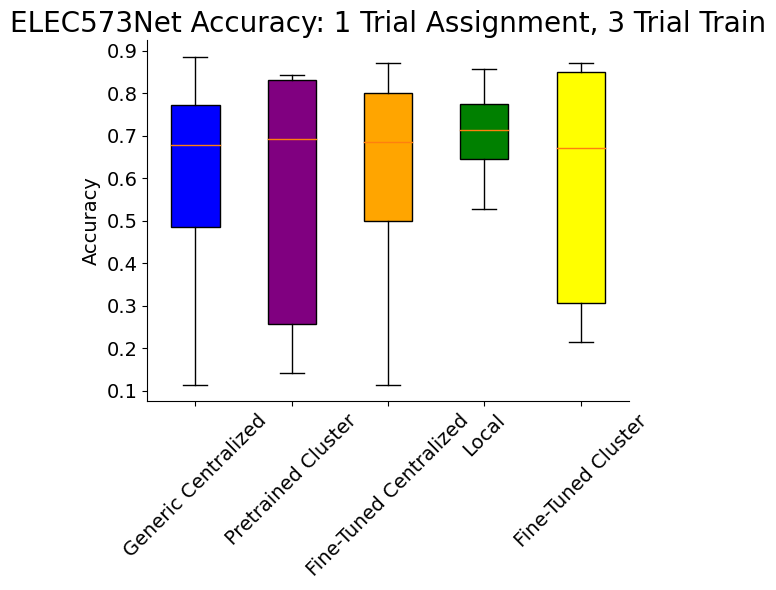

In [18]:
plot_model_acc_boxplots(data_dict_1_3, my_title=f"{MODEL_STR} Accuracy: 1 Trial Assignment, 3 Trial Train", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_3TT")


## Trying to improve cluster assignment: using 3 trials instead of just 1 (now all 3s)

In [19]:
data_dict_3_3 = full_comparison_run(data_splits, one_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                        nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')

PID P102, 0/8
Cluster 41 had the highest accuracy (0.8)
PID P103, 1/8
Cluster 38 had the highest accuracy (0.8)
PID P106, 2/8
Cluster 8 had the highest accuracy (0.3)
PID P110, 3/8
Cluster 37 had the highest accuracy (0.5)
PID P116, 4/8
Cluster 34 had the highest accuracy (0.9)
PID P118, 5/8
Cluster 41 had the highest accuracy (0.9)
PID P127, 6/8
Cluster 41 had the highest accuracy (0.2)
PID P132, 7/8
Cluster 38 had the highest accuracy (0.8)


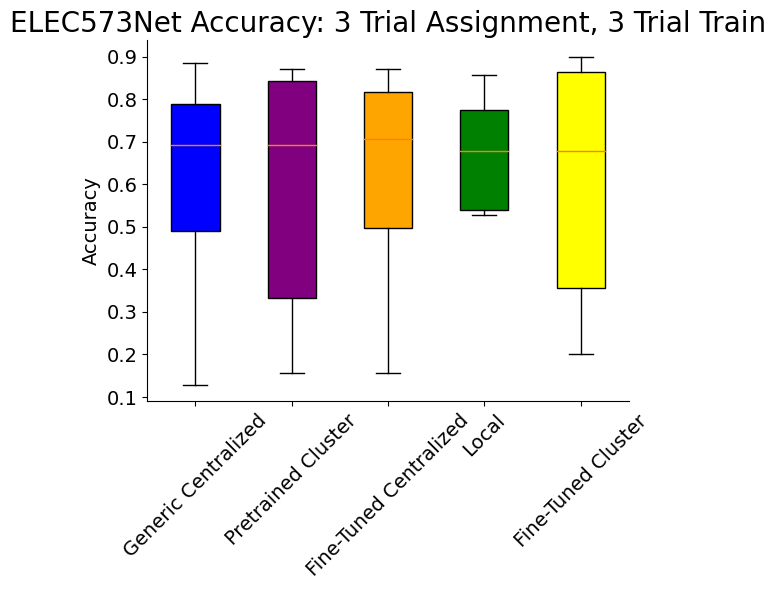

In [20]:
plot_model_acc_boxplots(data_dict_3_3, my_title=f"{MODEL_STR} Accuracy: 3 Trial Assignment, 3 Trial Train", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_3TA_3TT")


## Changing to use 5 trials for training (local+FT)

In [21]:
data_dict_5_5 = full_comparison_run(five_trial_data_splits, five_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                        nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')

PID P102, 0/8
Cluster 41 had the highest accuracy (0.64)
PID P103, 1/8
Cluster 38 had the highest accuracy (0.84)
PID P106, 2/8
Cluster 8 had the highest accuracy (0.2)
PID P110, 3/8
Cluster 37 had the highest accuracy (0.36)
PID P116, 4/8
Cluster 34 had the highest accuracy (0.84)
PID P118, 5/8
Cluster 41 had the highest accuracy (0.82)
PID P127, 6/8
Cluster 41 had the highest accuracy (0.2)
PID P132, 7/8
Cluster 38 had the highest accuracy (0.74)


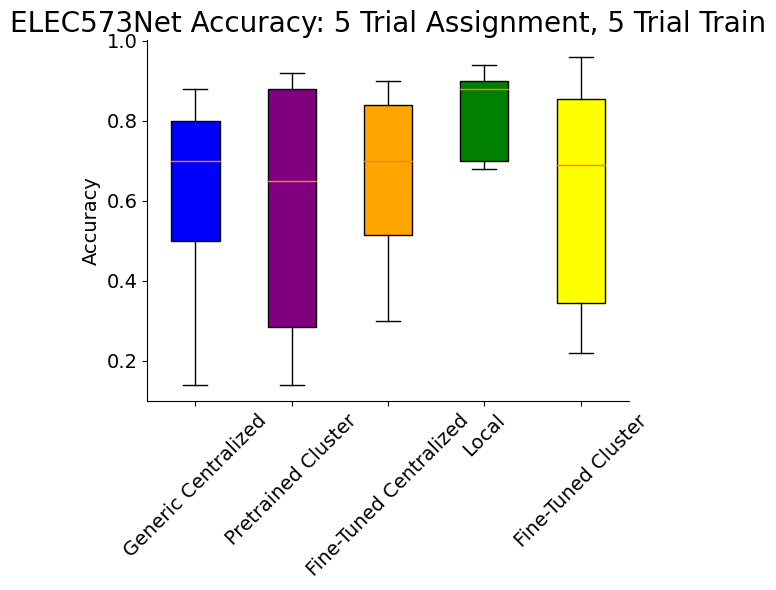

In [22]:
plot_model_acc_boxplots(data_dict_5_5, my_title=f"{MODEL_STR} Accuracy: 5 Trial Assignment, 5 Trial Train", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_5TA_5TT")


## Changing to use just 1 trial for training (local+FT)

In [23]:
data_dict_1_1 = full_comparison_run(one_trial_data_splits, one_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                        nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')

PID P102, 0/8
Cluster 41 had the highest accuracy (0.7)
PID P103, 1/8
Cluster 38 had the highest accuracy (0.8)
PID P106, 2/8
Cluster 8 had the highest accuracy (0.3)
PID P110, 3/8
Cluster 37 had the highest accuracy (0.5)
PID P116, 4/8
Cluster 34 had the highest accuracy (0.9)
PID P118, 5/8
Cluster 41 had the highest accuracy (0.9)
PID P127, 6/8
Cluster 41 had the highest accuracy (0.3)
PID P132, 7/8
Cluster 38 had the highest accuracy (0.7)


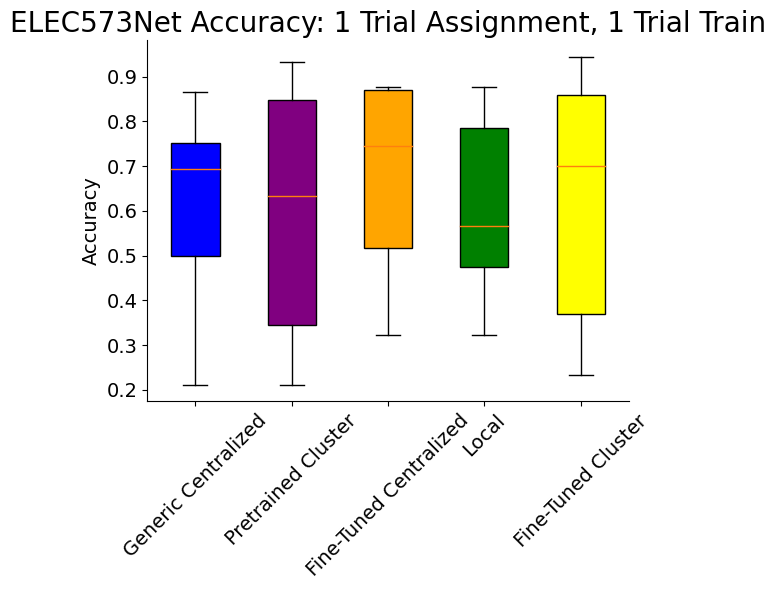

In [24]:
plot_model_acc_boxplots(data_dict_1_1, my_title=f"{MODEL_STR} Accuracy: 1 Trial Assignment, 1 Trial Train", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT")